In [1]:
from datasets import load_dataset

dataset_dir = "Aeala/ShareGPT_Vicuna_unfiltered"

ds = load_dataset(dataset_dir)
ds = ds['train']

/home/nctu/envs/eagle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

m0_name="meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(m0_name)

In [16]:
import torch
from fastchat.model.model_adapter import get_conversation_template

dataset_dir = "Aeala/ShareGPT_Vicuna_unfiltered"

def build_dataset_rank(
        tokenizer, split="train",
        select=None,
):
    # ds = load_dataset('json', data_files=data_dir)
    ds = load_dataset(dataset_dir)
    ds = ds['train']
    ds = ds.shuffle(seed=42)
    ds1 = ds.select(range(0, 68000))
    # ds1 = ds.select(range(100,200))
    # dst=ds.select(range(200,300))
    # ds2=ds.select(range(300,len(ds)))
    original_columns1 = ds1.column_names
    # original_columns2 = ds2.column_names
    num_proc = 32#16#64#16#4

    def preprocess_function(examples):
        new_examples = {
            "conversation":[],
            "input_ids": [],
            "loss_mask": []
        }
        for i in range(len(examples['id'])):
            conv = get_conversation_template("llama-2-chat")
            sys_p="You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."
            conv.system_message=sys_p
            roles = {"human": conv.roles[0], "gpt": conv.roles[1]}
            source= examples['conversations'][i]
            if roles[source[0]["from"]] != conv.roles[0]:
                # Skip the first one if it is not from human
                source = source[1:]
            conv.messages = []
            for j, sentence in enumerate(source):
                role = roles[sentence["from"]]
                assert role == conv.roles[j % 2], f"{i}"
                if sentence["from"]=="gpt":
                    sentence["value"]=" "+sentence["value"]
                conv.append_message(role, sentence["value"])
            conversation=conv.get_prompt()
            # if i==56:
            #     print(i)
            # if i==57:
            #     print(i)
            if not tokenizer.pad_token_id:
                tokenizer.pad_token_id=tokenizer.unk_token_id

            input_ids = tokenizer(
                conversation,
                return_tensors="pt",
                max_length=2048,
                truncation=True,
            ).input_ids[0]
            loss_mask=torch.ones_like(input_ids)
            #print(i)

            sep = conv.sep + conv.roles[1] + " "



            total_len = int(input_ids.ne(tokenizer.pad_token_id).sum())

            turns = conversation.split(conv.sep2)
            cur_len = 1
            loss_mask[:cur_len] = 0
            for i, turn in enumerate(turns):
                if turn == "":
                    break
                turn_len = len(tokenizer(turn).input_ids)

                parts = turn.split(sep)
                if len(parts) != 2:
                    break
                parts[0] += sep
                # "-2" is hardcoded for the Llama tokenizer to make the offset correct.
                instruction_len = len(tokenizer(parts[0]).input_ids) - 2

                # if i != 0 and not tokenizer.legacy:
                #     # The legacy and non-legacy modes handle special tokens differently
                #     instruction_len -= 1

                # Ignore the user instructions
                loss_mask[cur_len: cur_len + instruction_len] = 0
                cur_len += turn_len
                cur_len+=2

                if i != 0 and not tokenizer.legacy:
                    # The legacy and non-legacy modes handle special tokens differently
                    cur_len -= 1

            loss_mask[cur_len:] = 0



            new_examples["conversation"].append(conversation)
            new_examples["input_ids"].append(input_ids[None,:])
            new_examples["loss_mask"].append(loss_mask[None,:])

        return new_examples

    ds1 = ds1.map(
        preprocess_function,
        batched=True,
        num_proc=num_proc,
        remove_columns=original_columns1,
        load_from_cache_file=False
    )

    # ds1 = ds1.filter(lambda x: len(x["input_ids"]) < 1024, batched=False)
    # ds1 = ds1.filter(lambda x: x['queryf'] not in gqs, batched=False)
    # ds1 = ds1.filter(lambda x: "Are there any tips in regards to teaching" in x['queryf'], batched=False)

    ds1.set_format(type="torch")
    # ds2.set_format(type="torch")
    # dst.set_format(type="torch")
    return ds1

ds = build_dataset_rank(tokenizer)

Map (num_proc=32): 100%|██████████| 68000/68000 [00:18<00:00, 3667.31 examples/s] 


In [26]:
# obtain token id frequency in the dataset
from collections import Counter
import torch
from tqdm import tqdm

def get_token_id_freq(ds):
    token_id_freq = Counter()
    for i in tqdm(range(len(ds))):
        input_ids = ds[i]["input_ids"]
        token_id_freq.update(input_ids.view(-1).tolist())
    return token_id_freq

token_id_freq = get_token_id_freq(ds)

100%|██████████| 68000/68000 [00:25<00:00, 2710.26it/s]


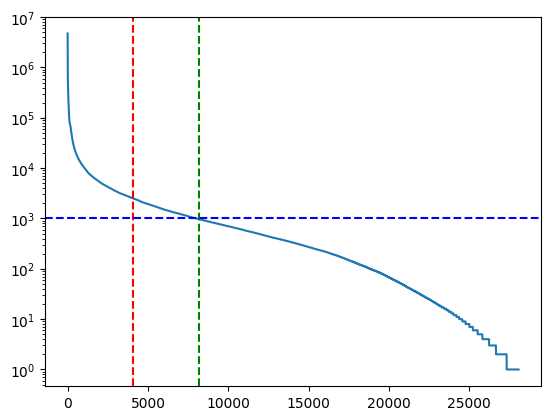

In [41]:
# plot
import matplotlib.pyplot as plt

token_id_freq_plt = dict(token_id_freq)
token_id_freq_plt = sorted(token_id_freq_plt.items(), key=lambda x: x[1], reverse=True)
token_id_freq_plt = list(zip(*token_id_freq_plt))

plt.plot(token_id_freq_plt[1])
plt.yscale("log")

#draw a line in 4096
plt.axvline(x=4096, color='r', linestyle='--')

#draw a line in 8192
plt.axvline(x=8192, color='g', linestyle='--')

# draw a line at 1000 threshold
plt.axhline(y=1000, color='b', linestyle='--')

plt.show()

In [48]:
KEEP_TOP_N = 8192
TOTAL_TOKENS = 32000

# generate an array of size 8192 with the most frequent token ids
top_token_ids = list(token_id_freq.keys())[:KEEP_TOP_N]
top_token_ids[KEEP_TOP_N-1] = -1
top_token_ids = torch.tensor(top_token_ids)

# save the top token ids
torch.save(top_token_ids, f"top_{KEEP_TOP_N}_id_map.pt")

#inverse mapping & index id
top_token_ids_map = {v: k for k, v in enumerate(top_token_ids.tolist())}
top_token_ids_map = torch.tensor([top_token_ids_map.get(i, KEEP_TOP_N-1) for i in range(TOTAL_TOKENS)])

# save the top token ids map
torch.save(top_token_ids_map, f"top_{KEEP_TOP_N}_id_map_inverse.pt")

# id mapping sorted by frequency
top_token_ids_freq = list(token_id_freq.keys())
top_token_ids_freq = torch.tensor(top_token_ids_freq)

# save the top token ids freq
torch.save(top_token_ids_freq, f"top_{KEEP_TOP_N}_id_map_freq.pt")

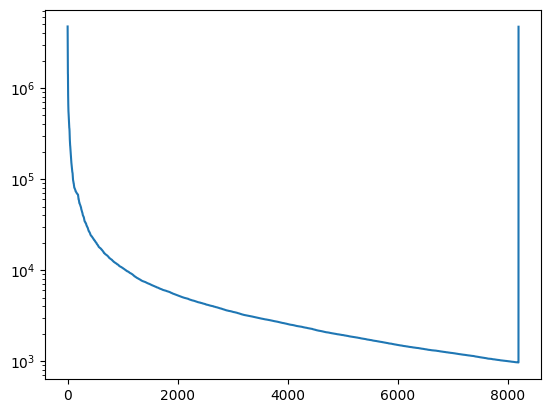

In [44]:
# sum all the values after 8191 to 8191, and plot
token_id_freq_test = dict(token_id_freq)
token_id_freq_test = sorted(token_id_freq_test.items(), key=lambda x: x[1], reverse=True)
# sum all the values after 8191 to 8191



def sum_after_num(token_id_freq_test, num=8192):
    token_id_freq_test = list(token_id_freq_test)
    
    # token_id_freq_test[8191] = sum(token_id_freq_test[8191:])
    total = 0
    for i in range(num-1, len(token_id_freq_test)):
        total += token_id_freq_test[i][1]
    token_id_freq_test[num-1] = (token_id_freq_test[num-1][0], total)
    token_id_freq_test = token_id_freq_test[:num]
    return token_id_freq_test

token_id_freq_test = sum_after_num(token_id_freq_test, num=KEEP_TOP_N)
token_id_freq_test = list(zip(*token_id_freq_test))

plt.plot(token_id_freq_test[1])
plt.yscale("log")

#draw a line in 8192
# plt.axvline(x=8192, color='r', linestyle='--')

plt.show()